<a href="https://colab.research.google.com/github/francesco-source/Machine-Learning/blob/main/Exam_07_02_2022_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exam of Machine Learning 07/02/2022

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid,GridSearchCV
from sklearn.feature_selection import SelectKBest,mutual_info_classif
from sklearn.metrics import silhouette_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler ,OneHotEncoder, OrdinalEncoder
from sklearn.metrics.cluster import pair_confusion_matrix
random_state = 42

## 1 Load the dataset1.csv and explore the data, showing size, structure and histograms of numeric data; show the histogram of the frequencies of the class labels, contained in the “y” column

In [133]:
data_s = pd.read_csv("exam_superv.csv")
data_s.head()

,0,1,y,2
0,1.589942,2.977770,0,1.953805
1,2.908437,1.837522,1,1.510049
2,3.284091,1.818476,1,3.307287
3,3.148717,2.071991,1,3.452021
4,2.116881,2.133874,0,2.157870


In [134]:
print("The size of the dataset is",data_s.size,".")
print("The shape of the dataset is", data_s.shape,".")

The size of the dataset is 4800 .
The shape of the dataset is (1200, 4) .


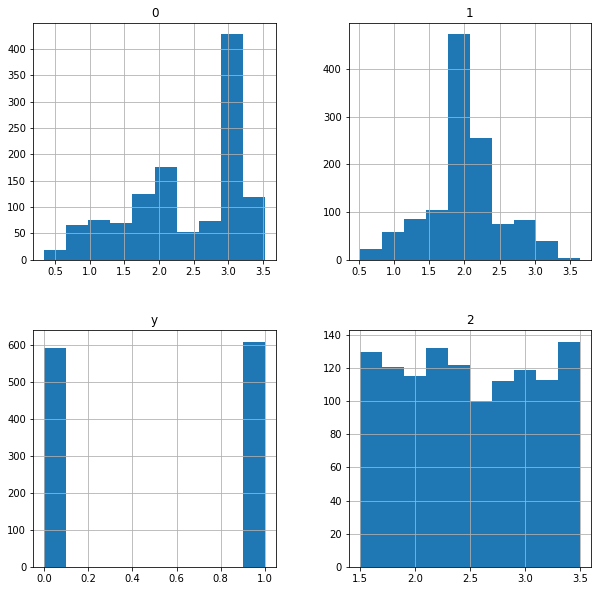

In [135]:
pd.DataFrame.hist(data_s
                  , figsize = [10,10]
                 );

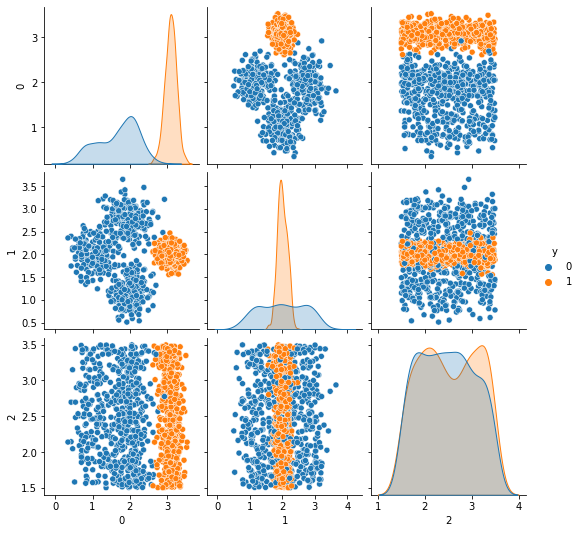

In [136]:
sns.pairplot(data_s, hue = "y")

## 2 drop the column “y” and find the best clustering scheme and hyper–parameters able to reproduce the y column (hint: before clustering you can consider dropping columns with little correlation to “y”; perhaps you should consider more than one estimator for clustering) 

Looking at the data we can see that the variable 2 has a small correlation with the y variable. So it's maily noise and can be dropped.

In [137]:
X = data_s.drop(["y","2"],axis =1)

#### Now I try the K_Means cause the data have no concavities 

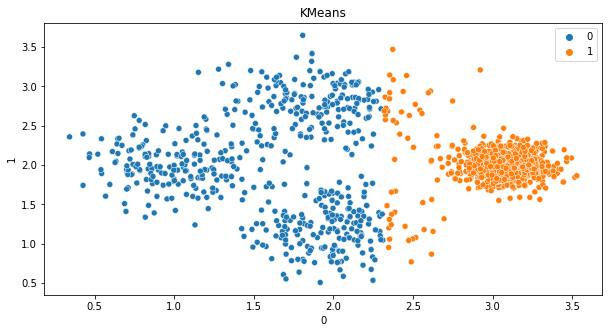

In [138]:
km = KMeans(n_clusters=2, random_state = random_state)
y_km = km.fit_predict(X)

plt.figure(figsize= [10,5])
plt.title("KMeans")
sns.scatterplot(x= X["0"],y=X["1"],hue = y_km);


It's not the same as the gold standard. But we know that the number of clusters must be two so I try a different clustering scheme like agglomerative clustering.

#### Now I try Agglomerative clustering

In [139]:
result_ac = []
param_grid ={"linkage":['ward', 'complete', 'average', 'single']}
param_grid = ParameterGrid(param_grid)
for par in param_grid:
    agc = AgglomerativeClustering(n_clusters = 2, linkage = par.get("linkage"))
    y_agc = agc.fit_predict(X)
    result_ac.append([par.get('linkage'),silhouette_score(X,y_agc)])

df_result_ac = pd.DataFrame(data = result_ac, columns=['linkage','silhouette_score'])
df_result_ac.sort_values(by='silhouette_score', ascending=False).head(5)

,linkage,silhouette_score
0,ward,0.553130
2,average,0.521578
1,complete,0.519470
3,single,0.215997


Also using Agglomerative clustering we can find a number of clusters that is equal to 4. 

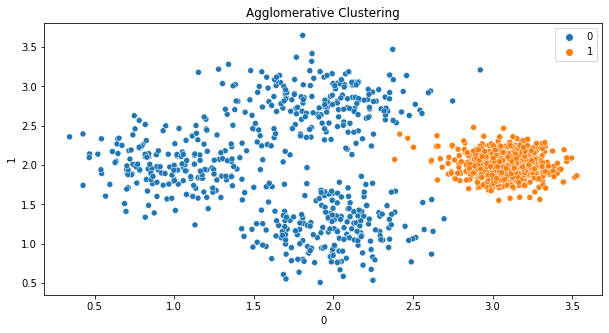

In [140]:
agc = AgglomerativeClustering(n_clusters = 2, linkage = "ward")
y_agc = agc.fit_predict(X)

plt.figure(figsize= [10,5])
plt.title("Agglomerative Clustering")
sns.scatterplot(x= X["0"],y=X["1"],hue = y_agc);

#### Now I try to use DBSCAN

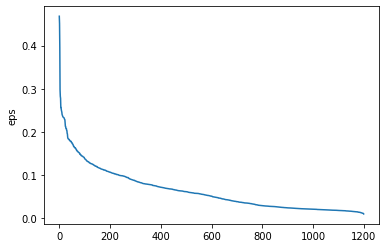

In [141]:
min_points=2*X.shape[1]
k_distances = []
for i in range(0, X.shape[0]):
    k_point_distances = []
    for j in range(0, X.shape[0]):
        if i!=j:
            dist = np.sqrt(sum((X.values[i,:]-X.values[j,:])**2))
            k_point_distances.append(dist)
    k_point_distances.sort()
    k_distances.append(k_point_distances[min_points-1])
    
k_distances.sort(reverse=True)
plt.plot(range(0,len(k_distances)), k_distances)
plt.ylabel("eps")
plt.show()

In [142]:
parameter_grid = ParameterGrid({"eps":np.arange(0.1,3,0.01),"min_samples":range(min_points,min_points+10)})
param_grid = list(parameter_grid)
dbscan_out = pd.DataFrame(columns =  ['eps','min_samples','n_clusters','silhouette', 'unclust%'])
for i in param_grid:
    db = DBSCAN(eps=i.get("eps"),min_samples=i.get("min_samples"))
    y_db = db.fit_predict(X)
    cluster_labels_all = np.unique(y_db)
    cluster_labels = cluster_labels_all[cluster_labels_all != -1]
    n_clusters = len(cluster_labels)
    if n_clusters > 1:
        X_cl = X.values[y_db != -1,:]# elimino tutte le righe facenti parte del rumore
        y_db_cl = y_db[y_db != -1] # elimino dalle lables tutti i valori che fanno parte del rumore
        silhouette = silhouette_score(X_cl,y_db_cl)
        uncl_p = (1 - (len(y_db_cl)/len(y_db)))*100
        dbscan_out.loc[len(dbscan_out)] = [db.eps, db.min_samples, n_clusters, silhouette, uncl_p]

In [143]:
sil_thr = 0.5 
data_frame_db = dbscan_out[(dbscan_out['silhouette']>=sil_thr) & (dbscan_out['n_clusters']==2)]
data_frame_db.sort_values(by='unclust%', ascending=True).head(5)

,eps,min_samples,n_clusters,silhouette,unclust%
128,0.26,13.0,2.0,0.557147,0.500000
117,0.23,9.0,2.0,0.557404,0.500000
122,0.24,10.0,2.0,0.557364,0.500000
126,0.25,12.0,2.0,0.557524,0.583333
124,0.24,12.0,2.0,0.557524,0.583333


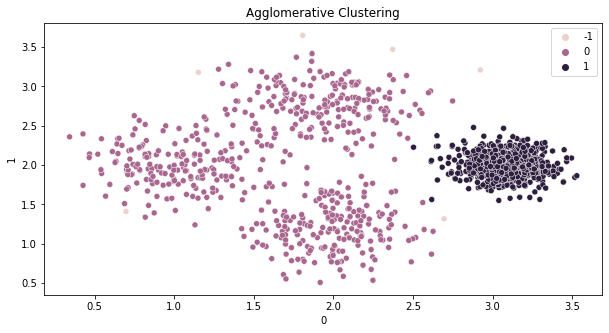

In [144]:
db = DBSCAN(eps=0.26,min_samples=13)
y_db = db.fit_predict(X)

plt.figure(figsize= [10,5])
plt.title("Agglomerative Clustering")
sns.scatterplot(x= X["0"],y=X["1"],hue = y_db);

I choose DBSCAN because it's the best clustering scheme for this dataset beause it's able to almost reproduce the gold standard

## 3 show the difference between the original “y” column and the labels generated by the clustering, it can be expressed as “accuracy”, produce also the confusion matrix

In [145]:
print("The accuracy is: ", np.round(accuracy_score(data_s["y"],y_db),4))

The accuracy is:  0.9917


In [146]:
p_c_m = pair_confusion_matrix(data_s["y"],y_db)
print("The pair confusion matrix is ")
p_c_m = p_c_m/ p_c_m.sum()
p_c_m

The pair confusion matrix is 


array([[0.49691827, 0.00338616],
       [0.00810954, 0.49158604]])

## 4.  apply the same transformations, to dataset2.csv, then apply the best clustering scheme and hyper parameters and plot the data with the assigned labels

In [147]:
data_uns = pd.read_csv("exam_unsuperv.csv")
data_uns.head()

,0,1,2
0,3.185684,2.208597,3.045639
1,2.179220,1.410352,2.396246
2,2.242676,2.624663,2.833286
3,1.980176,0.836695,2.188114
4,3.210992,2.251962,3.309826


In [148]:
db = DBSCAN(eps=0.26,min_samples=16)
X_uns = data_uns.drop(["2"],axis = 1)
y_db_pred = db.fit_predict(X_uns)

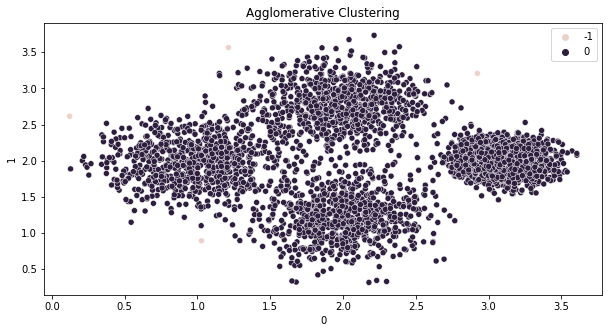

In [149]:
plt.figure(figsize= [10,5])
plt.title("Agglomerative Clustering")
sns.scatterplot(x= X_uns["0"],y=X_uns["1"],hue = y_db_pred);

#### applying The same clustering scheme, however, doesnt' bring the same good results, so probabily a best set of hyperparameter should be chosen